In [ ]:
from typing import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils

In [ ]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data/")
image_path = data_path / "Apples-bananas"


if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)


    with open(data_path / "Apples-bananas.zip", "wb") as f:
        request = requests.get("https://github.com/AliFarajiyan/AutoEncoder/raw/main/Apples-bananas.zip")
        print("Downloading Apples, bananas data...")
        f.write(request.content)


    with zipfile.ZipFile(data_path / "Apples-bananas.zip", "r") as zip_ref:
        print("Unzipping Apples, bananas data...")
        zip_ref.extractall(image_path)

Did not find data/Apples-bananas directory, creating one...
Unzipping Apples, bananas data...


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])

In [ ]:
dataset = ImageFolder(root=image_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
# %% model class
LATENT_DIMS = 128
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)  # out: 6, 62, 62
        self.conv2 = nn.Conv2d(6, 16, 3) # out: 16, 60, 60
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() # out: 16*60*60 = 57600
        self.fc = nn.Linear(16*60*60, LATENT_DIMS)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc = nn.Linear(LATENT_DIMS, 16*60*60)
        self.conv2 = nn.ConvTranspose2d(16, 6, 3)
        self.conv1 = nn.ConvTranspose2d(6, 1, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 16, 60, 60)  # infer first dim from other dims
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input = torch.rand((1, 1, 64, 64))
model = Autoencoder()
model(input).shape

torch.Size([1, 1, 64, 64])

In [ ]:
#%% init model, loss function, optimizer
model = Autoencoder()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 30

for epoch in range(NUM_EPOCHS):
    losses_epoch = []
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.view(-1, 1, 64, 64)
        output = model(data)

        loss = F.mse_loss(output, data)
        losses_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch} \tLoss: {np.mean(losses_epoch)}")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 0 	Loss: 0.5513035468757153
Epoch: 1 	Loss: 0.4246877692639828
Epoch: 2 	Loss: 0.40337013515333336
Epoch: 3 	Loss: 0.4017671657105287
Epoch: 4 	Loss: 0.3974893440802892
Epoch: 5 	Loss: 0.38960211848219234
Epoch: 6 	Loss: 0.3830130733549595
Epoch: 7 	Loss: 0.37506679569681484
Epoch: 8 	Loss: 0.36555436874429387
Epoch: 9 	Loss: 0.34885752263168496
Epoch: 10 	Loss: 0.355209627499183
Epoch: 11 	Loss: 0.3474419452250004
Epoch: 12 	Loss: 0.3336167763918638
Epoch: 13 	Loss: 0.3390484427412351
Epoch: 14 	Loss: 0.3301980346441269
Epoch: 15 	Loss: 0.3227853092054526
Epoch: 16 	Loss: 0.3141634414593379
Epoch: 17 	Loss: 0.3085590898990631
Epoch: 18 	Loss: 0.30763410155971843
Epoch: 19 	Loss: 0.30391554658611614
Epoch: 20 	Loss: 0.30109465184311074
Epoch: 21 	Loss: 0.2937959401557843
Epoch: 22 	Loss: 0.2939659748226404
Epoch: 23 	Loss: 0.28774173992375535
Epoch: 24 	Loss: 0.29244688525795937
Epoch: 25 	Loss: 0.2854999539752801
Epoch: 26 	Loss: 0.28281836956739426
Epoch: 27 	Loss: 0.278657271

In [ ]:
# %% visualise original and reconstructed images
def show_image(img):
    img = 0.5 * (img + 1)  # denormalizeA

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


original


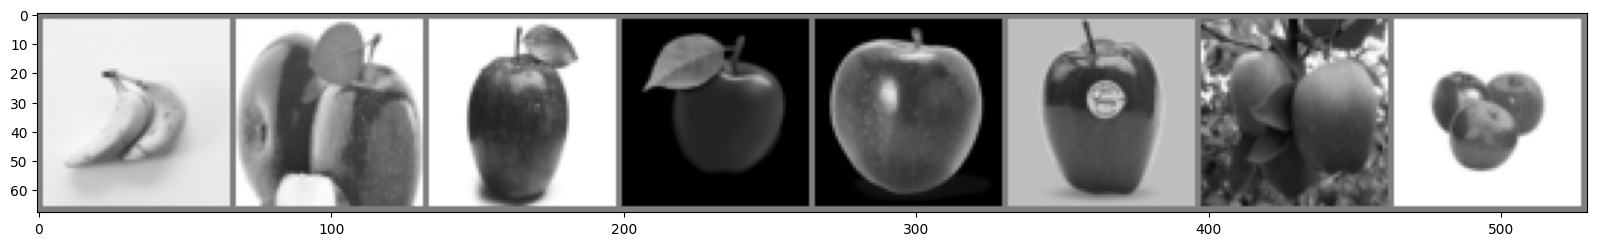

In [ ]:
images, labels = next(iter(dataloader))
print('original')
plt.rcParams["figure.figsize"] = (20,3)
show_image(torchvision.utils.make_grid(images))

latent space


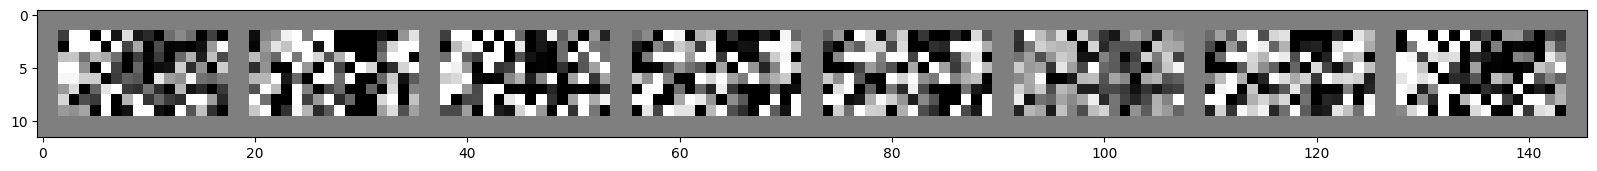

In [ ]:
# %% latent space
print('latent space')
latent_img = model.encoder(images)
latent_img = latent_img.view(-1, 1, 8, 16)
show_image(torchvision.utils.make_grid(latent_img))

reconstructed


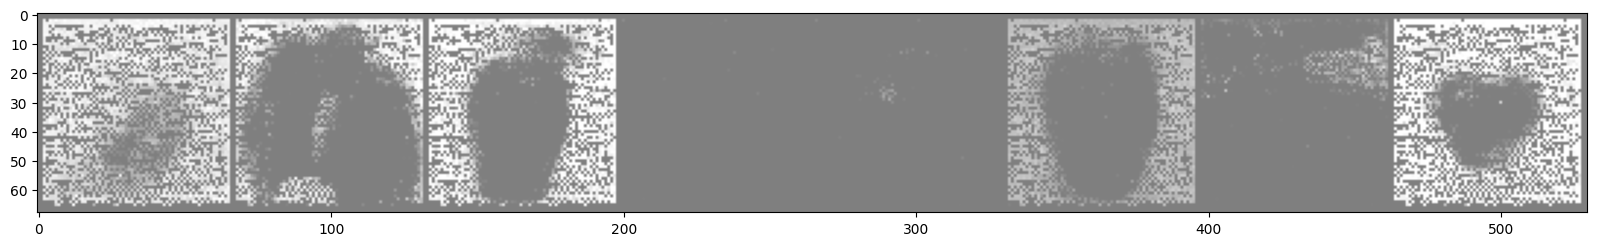

In [ ]:
print('reconstructed')
show_image(torchvision.utils.make_grid(model(images)))

In [ ]:
# %% Compression rate
image_size = images.shape[2] * images.shape[3] * 1
compression_rate = (1 - LATENT_DIMS / image_size) * 100
compression_rate

96.875